<center>
 <h1> STYLEGAN2-ADA NOTEBOOK : DIFFERENCES BETWEEN PCA AND KPCA <h1>
<center>

<center>
  Ce notebook nous a permis de comparer les résultats acquis par PCA et par KPCA. Il est séparé du notebook implémentant le PCA car il était destiné à être utilisé seulement sur les cpu et non pas sur les gpu comme pour la génération d'images. 
</center>


# Importing libraries 

In [1]:
import generate_nb
import matplotlib.pyplot as plt
import torch
import numpy as np
import dnnlib
import legacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import importlib
import projector_nb
importlib.reload(projector_nb)
import numpy as np
import torch
import os
import imageio
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
print(torch.cuda.is_available())
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

False
cpu


# Getting started with the generating function



In [4]:
image = generate_nb.generate_images(
    network_pkl='https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl',
    seeds=[245],  # single seed for one image
    truncation_psi=1,
    noise_mode='const',
    outdir='out',
    class_idx=None,
    projected_w=None,
    show=True
)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl"...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Generating image for seed 245 (0/1) ...


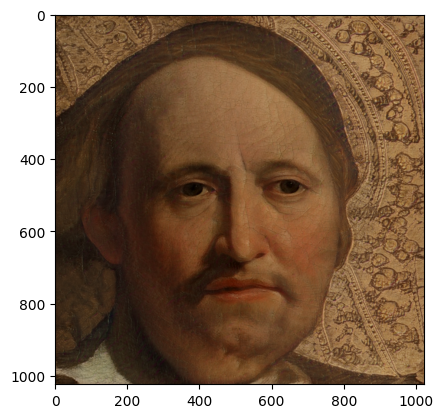

In [5]:
plt.imshow(image)

# Loading the network

In [3]:
network = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
name = 'out/seed0085.png'
outdir = 'ignored_outputs'

In [4]:
with dnnlib.util.open_url(network) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


# Generating the samples

In [5]:
def generate_samples(G, num_samples):
    z_samples = np.random.RandomState().randn(num_samples, 512).astype(np.float32) 
    
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy()
    w_samples = w_samples[:,0,:]

    return w_samples

def get_pca(samples):
    
    scaler = StandardScaler()
    w_samples = scaler.fit_transform(samples)  

    pca = PCA(n_components=100)
    pca.fit(w_samples)

    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance')
    plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative Explained Variance')

    plt.xlabel('Principal Component Index')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return pca , scaler

In [6]:
w_samples = generate_samples(G, 50000)

# Trying two PCAs with 20 000 samples


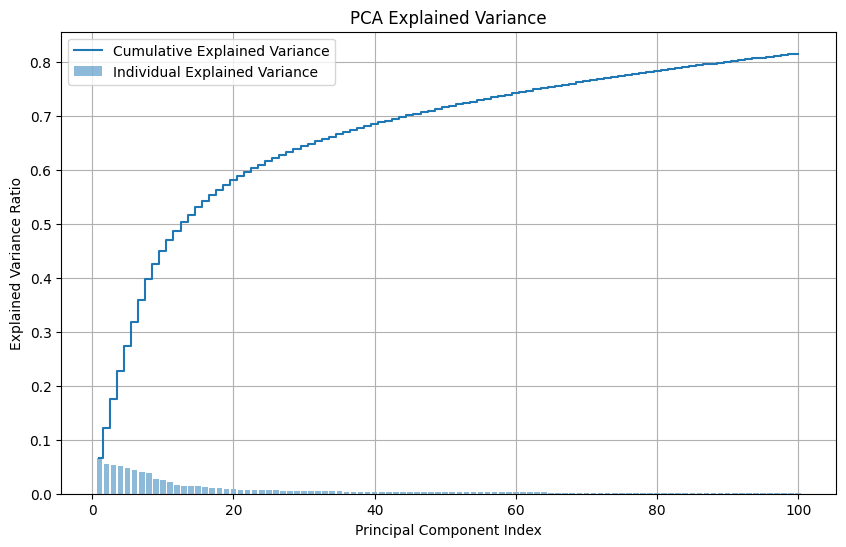

In [7]:
pca , scaler = get_pca(w_samples)

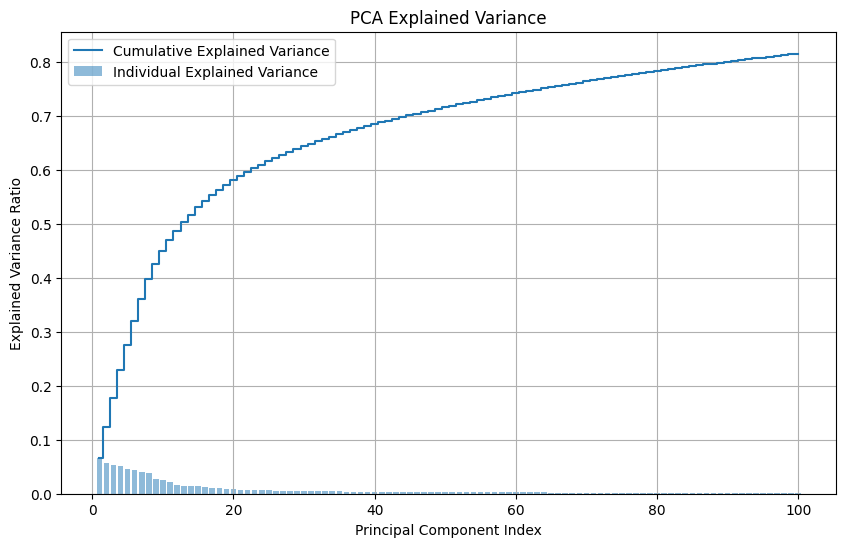

In [19]:
pca2 , scaler2 = get_pca(w_samples)



---

## Trying Kernel PCA instead of PCA on 10 000 samples


In [8]:
w_samples_kpca = generate_samples(G,10000)

KPCA = KernelPCA(n_components=100,  kernel='rbf', coef0=1,fit_inverse_transform=True)
scaler = StandardScaler()
w_samples_kpca = scaler.fit_transform(w_samples_kpca) 

In [9]:
KPCA.fit(w_samples_kpca)

KernelPCA(fit_inverse_transform=True, kernel='rbf', n_components=100)

In [10]:
dump(KPCA, 'kpca_model_rbf_100compo_10000sampels.joblib')

['kpca_model_rbf_100compo_10000sampels.joblib']

In [11]:
import sklearn
import joblib

print("scikit-learn version:", sklearn.__version__)
print("joblib version:", joblib.__version__)


scikit-learn version: 1.5.0
joblib version: 1.0.1


In [12]:
file_path = "kpca_model_rbf_100compo_10000sampels.joblib"

if os.path.exists(file_path):
    print(f"File {file_path} exists. Attempting to load...")
    try:
        KPCA_kernel = load(file_path)
        print("File loaded successfully.")
    except Exception as e:
        print(f"Error loading file: {e}")
        print("Try re-downloading the file.")
else:
    print(f"File {file_path} does not exist. Please download the file again.")


File kpca_model_rbf_100compo_10000sampels.joblib exists. Attempting to load...
File loaded successfully.


# Comparison between PCA and KPCA space


In [47]:
z_sample = np.random.randn(1, 512).astype(np.float32) 
w_sample = G.mapping(torch.from_numpy(z_sample).to(device), None)

w_sample = w_sample.cpu().numpy()
w_sample = w_sample[:, 1, :]  
w_sample = scaler.transform(w_sample)

In [13]:
def create_deplacement_pca(pca,direction):

    # displacement using pca
    V = pca.components_.T
    explained_variance = pca.explained_variance_

    x_pca = np.zeros((V.shape[1], 1))
    X_pca =  np.tile(x_pca, (1, 100))

    sigma = np.sqrt(explained_variance[direction])
    start_value = -2* sigma
    end_value = 2* sigma
    arrays_between = np.linspace(start_value, end_value, 100 + 2)[1:-1]
    X_pca[direction] = arrays_between
    
    deplacement_list_pca = []

    for i in range(X_pca.shape[1]):
        x_tmp = X_pca[:,i]
        movement = V @ x_tmp
        movement = np.expand_dims(movement, axis=1)
        deplacement_list_pca.append(movement.T)

    return deplacement_list_pca


def create_deplacement_kpca(kpca,direction):
    w_transformed = kpca.transform(w_samples) # w_transformed will enable us to have the size of teh vector in the kpca space
    eigenvalues = kpca.eigenvalues_

    x_kpca = np.zeros((w_transformed.shape[1], 1))
    X_kpca =  np.tile(x_kpca, (1, 100))

    sigma = np.sqrt(eigenvalues[direction])
    start_value = -2* sigma
    end_value = 2* sigma
    arrays_between = np.linspace(start_value, end_value, 100 + 2)[1:-1]
    X_kpca[direction] = arrays_between
    
    deplacement_list_kpca = []

    for i in range(X_kpca.shape[1]):
        x_tmp = X_kpca[:,i]
        movement = kpca.inverse_transform(x_tmp.reshape(1, -1))
        deplacement_list_kpca.append(movement)
        
    return deplacement_list_kpca

deplacement_list_pca = create_deplacement_pca(pca,0)

**KPCA with rbf kernel**

In [59]:
# with the same sampling : KPCA (10 000 samples) and PCA (10 000 samples) for fitting

deplacement_list_kpca_rbf = create_deplacement_kpca(KPCA_kernel,0)

euclidean_distance_2sigma = np.linalg.norm(deplacement_list_kpca_rbf[0] - deplacement_list_pca[0])
print(euclidean_distance_2sigma)


cosine_sim = cosine_similarity(deplacement_list_kpca_rbf[0] , deplacement_list_pca[0])
print(cosine_sim)

76.49095330566371
[[0.55268687]]


In [14]:
# with two different sampling : KPCA (10 000 samples) and PCA (50 000 samples) for training

deplacement_list_kpca_rbf = create_deplacement_kpca(KPCA_kernel,0)

euclidean_distance_2sigma = np.linalg.norm(deplacement_list_kpca_rbf[0] - deplacement_list_pca[0])
print(euclidean_distance_2sigma)


cosine_sim = cosine_similarity(deplacement_list_kpca_rbf[0] , deplacement_list_pca[0])
print(cosine_sim)

79.16801051499615
[[0.41431137]]


In [50]:
# with two different sampling but KPCA (1000 samples) and PCA (100 000 samples) for fitting

deplacement_list_kpca_rbf = create_deplacement_kpca(KPCA_kernel,0)

euclidean_distance_2sigma = np.linalg.norm(deplacement_list_kpca_rbf[0] - deplacement_list_pca[0])
print(euclidean_distance_2sigma)


cosine_sim = cosine_similarity(deplacement_list_kpca_rbf[0] , deplacement_list_pca[0])
print(cosine_sim)

10.013396901249164
[[0.78612729]]
